In [0]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import joblib
import pickle
import datetime
import random
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,TensorBoard,LearningRateScheduler
from nltk.translate import bleu_score

<h1 style="font-size:35px"><center>Encoder Decoder Model

In [0]:
!wget --header="Host: doc-0c-4g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/0/folders/1Nz-Vq0RhziotMAesPgnisN_Ti9HNQ51f" --header="Cookie: AUTH_bfhjrtscq695ib7edi83p6bfm42sd929_nonce=ik8omm9uggl20; _ga=GA1.2.1509677474.1591248567" --header="Connection: keep-alive" "https://doc-0c-4g-docs.googleusercontent.com/docs/securesc/oik9lo733t355n1nglla0cdlqj79umtt/ehk8e924a2ltko8e12d28qusuc9agoer/1591653375000/00136369994752382157/00136369994752382157/16WsaIFQ3eMopsTJtclGqj4jSlyITPFx5?e=download&authuser=0&nonce=ik8omm9uggl20&user=00136369994752382157&hash=1sg7b7uhncfiv9ctkbq68jk0tcprr0rp" -c -O 'encoded_data'

--2020-06-08 21:57:26--  https://doc-0c-4g-docs.googleusercontent.com/docs/securesc/oik9lo733t355n1nglla0cdlqj79umtt/ehk8e924a2ltko8e12d28qusuc9agoer/1591653375000/00136369994752382157/00136369994752382157/16WsaIFQ3eMopsTJtclGqj4jSlyITPFx5?e=download&authuser=0&nonce=ik8omm9uggl20&user=00136369994752382157&hash=1sg7b7uhncfiv9ctkbq68jk0tcprr0rp
Resolving doc-0c-4g-docs.googleusercontent.com (doc-0c-4g-docs.googleusercontent.com)... 74.125.128.132, 2a00:1450:4013:c02::84
Connecting to doc-0c-4g-docs.googleusercontent.com (doc-0c-4g-docs.googleusercontent.com)|74.125.128.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘encoded_data’

encoded_data            [  <=>               ]   7.08M  11.1MB/s    in 0.6s    

2020-06-08 21:57:29 (11.1 MB/s) - ‘encoded_data’ saved [7426606]



<h1>1. Read Featurized data</h1> 
<h2>(Refer Word Featurization Section 3 of 2_Data_Featurization.ipynb)</h2> 

In [0]:
[X_train_padded_docs,y_train_padded_docs,X_val_padded_docs,y_val_padded_docs,inp_embedding_matrix,
                             out_embedding_matrix,inp_tokenizer,out_tokenizer] = joblib.load('encoded_data')

<h1>2. Modelling

<h2>2.1. Encoder Model

In [0]:
#Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,enc_units,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, weights=[embedding_matrix],
                                   mask_zero=True,name='Encoder_Embedding',trainable=False)
        self.lstm = LSTM(self.enc_units,return_sequences=True,return_state=True,name='Encoder_LSTM',dropout=0.33)

    def call(self, x):
        x = self.embedding(x)
        
        #state_c = Cell state output of last time step
        encoder_outputs, _, state_c = self.lstm(x)

        #Take average of encoder_outputs
        hidden = tf.reduce_mean(encoder_outputs,1)
        
        return hidden, state_c

In [4]:
inp_vocab_size = len(inp_tokenizer.word_index) + 1
print('Input Vocab size:',inp_vocab_size)

Input Vocab size: 1470


In [5]:
#Create encoder object
BATCH_SIZE = 32
encoder = Encoder(vocab_size=inp_vocab_size,embedding_dim=300,embedding_matrix=inp_embedding_matrix,
                  enc_units=256,name='Encoder')

#Sample input to encoder
example_input_batch, example_target_batch = X_train_padded_docs[:BATCH_SIZE], y_train_padded_docs[:BATCH_SIZE]
print('Shape of batch input data (batch_size,sequence length):',example_input_batch.shape)
print('Shape of batch output data (batch_size,sequence length):',example_target_batch.shape)

#Genearte sample hidden state from encoder object
sample_hidden_output, sample_cell_output = encoder(example_input_batch)
print('Shape of average hidden state output (batch_size,units):',sample_hidden_output.shape)
print('Shape of average memory state output (batch_size,units):',sample_cell_output.shape)

Shape of batch input data (batch_size,sequence length): (32, 23)
Shape of batch output data (batch_size,sequence length): (32, 23)
Shape of average hidden state output (batch_size,units): (32, 256)
Shape of average memory state output (batch_size,units): (32, 256)


<h2>2.2. Decoder Model

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,
                                            weights=[embedding_matrix],mask_zero=True,name='Decoder_Embedding',trainable=False)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,return_sequences=True,return_state=True,name='Decoder_LSTM',
                                         dropout=0.33)
        self.batch_norm = BatchNormalization()
        
    def call(self, x, hidden, cell):
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # passing the concatenated vector to the LSTM
        lstm_output, state_h, state_c = self.lstm(x,initial_state=[hidden,cell])
        
        #Normalise output
        lstm_output = self.batch_norm(lstm_output)
        
        return lstm_output,state_h,state_c

In [7]:
out_vocab_size = len(out_tokenizer.word_index) + 1
print('Output Vocab size:',out_vocab_size)

Output Vocab size: 1469


In [8]:
#Initialise one step decoder
BATCH_SIZE = 32
dec = Decoder(vocab_size=out_vocab_size,embedding_dim=300,embedding_matrix=out_embedding_matrix,dec_units=256)

#Geneate sample output and hidden states from decoder object
sample_output_dec,sample_hidden_output_dec,sample_cell_output_dec = dec(example_target_batch,sample_hidden_output,
                                                                        sample_cell_output)
print('Decoder:')
print('Shape of decoder input (batch_size,sequence_length):',example_target_batch.shape)
print('Shape of decoder output (batch_size,sequence_length,units):',sample_output_dec.shape)
print('Shape of decoder hidden state output (batch_size,units):',sample_hidden_output_dec.shape)
print('Shape of decoder memory state output (batch_size,units):',sample_cell_output_dec.shape)

Decoder:
Shape of decoder input (batch_size,sequence_length): (32, 23)
Shape of decoder output (batch_size,sequence_length,units): (32, 23, 256)
Shape of decoder hidden state output (batch_size,units): (32, 256)
Shape of decoder memory state output (batch_size,units): (32, 256)


<h2>2.3. Model

In [0]:
class Encoder_Decoder_Model(tf.keras.models.Model):
    def __init__(self, inp_vocab_size,out_vocab_size,embedding_dim,inp_embedding_matrix,out_embedding_matrix,units,**kwargs):
        super(Encoder_Decoder_Model,self).__init__(**kwargs)
        self.encoder = Encoder(vocab_size=inp_vocab_size, embedding_dim=embedding_dim,embedding_matrix=inp_embedding_matrix,
                               enc_units=units,name='Encoder_layer')
        self.decoder = Decoder(vocab_size=out_vocab_size, embedding_dim=embedding_dim,embedding_matrix=out_embedding_matrix,
                               dec_units=units,name='Decoder_layer')
        self.drop = Dropout(0.2,name='Dropout')
        self.dense = Dense(out_vocab_size,name='Output_layer')
        
    def call(self, inputs):
        #Inputs will contain encoder input and decoder input
        #Separate encoder and decoder inputs
        encoder_inputs, decoder_inputs = inputs[0], inputs[1]
        
        #Genearte output and hidden states from encoder object
        enc_hidden_output, enc_cell_output = self.encoder(encoder_inputs)

        #Generate output from decoder
        #Initialise hidden states of decoder with hidden states of encoder
        decoder_outputs,_,_ = self.decoder(decoder_inputs,enc_hidden_output,enc_cell_output)

        #Dropout
        decoder_outputs = self.drop(decoder_outputs)
        
        #Shape of outputs = (batch_size,timesteps,vocab_size)
        outputs = self.dense(decoder_outputs)
        
        return outputs

<h2>2.4. Loss function

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    
    #Identify zeros in real tensor/Creating masking tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #Calculate log loss for each class
    loss_ = loss_object(real, pred)
    #Change data type of mask
    mask = tf.cast(mask, dtype=loss_.dtype)
    #Calculate loss considering masking
    loss_ *= mask

    return tf.reduce_mean(loss_)

<h2>2.5. Model Evaluation

In [0]:
#Function returns texts from a sequence
def get_text_from_seq(sequence,tokenizer):
    sent =''
    for i in sequence:
        if i!=0:
            sent+=tokenizer.index_word[i]+' '
    return sent

In [0]:
#Function to get bleu score for a sentence
def get_bleu_score(enc_dec_model,input_seq,expected_output_seq):
    
    input_max_length = X_train_padded_docs.shape[1]
    output_max_length = y_train_padded_docs.shape[1]
    
    #Get output from encoder
    enc_hidden,enc_cell = enc_dec_model.layers[0](input_seq.reshape(1,input_max_length))
    
    #Boundary case for decoder
    dec_input = tf.expand_dims([out_tokenizer.word_index['<start>']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    
    #Predicted output sequence
    #Add <start> token to output sequence
    output_seq = [out_tokenizer.word_index['<start>']]
    
    #The model will start predicting after start token, hence max_length is subtracted by 1
    for i in range(output_max_length-1):
        #Get prediction from decoder
        dec_output,dec_hidden,dec_cell = enc_dec_model.layers[1](dec_input,dec_hidden,dec_cell)
        
        #Get prediction from dense layer
        #Shape == (batch_size,timestep,vocab_size) == (1,1,vocab_size)
        outputs = enc_dec_model.layers[3](dec_output)
        
        #Extract predicted id from decoder output
        key = np.argmax(outputs.numpy().reshape(-1))
        
        output_seq.append(key)
        
        if out_tokenizer.index_word[key] == '<end>':
            #Get texts from input sentence
            input_sent = get_text_from_seq(input_seq,inp_tokenizer)
            #Get texts from sequence for actual sentence
            actual = get_text_from_seq(expected_output_seq,out_tokenizer)
            #Get texts from sequence for predicted sentence
            prediction = get_text_from_seq(output_seq,out_tokenizer)
            return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    input_sent = get_text_from_seq(input_seq,inp_tokenizer)
    actual = get_text_from_seq(expected_output_seq,out_tokenizer)
    prediction = get_text_from_seq(output_seq,out_tokenizer)
    return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())

<h1>3. Model Training

In [0]:
#Set Parameters
inp_vocab_size = len(inp_tokenizer.word_index) + 1  
out_vocab_size = len(out_tokenizer.word_index) + 1 
#Encoding and decoding Embedding layer dimension
embedding_dim = 300
#Encoding and decoding LSTM layer units
units = 256

#Initialise object for Model class
model = Encoder_Decoder_Model(inp_vocab_size,out_vocab_size,embedding_dim,inp_embedding_matrix,
                              out_embedding_matrix,units,name='Encoder_Decoder_Model')

In [15]:
#Max sequence length for input = max_length
#Max sequence length for output = max_length-1, 1 is subtracted because <end> token should not be give input to decoder
model.build(input_shape=[(None,X_train_padded_docs.shape[1]),(None,y_train_padded_docs.shape[1]-1)])
model.summary()

Model: "Encoder_Decoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_layer (Encoder)      multiple                  1011368   
_________________________________________________________________
Decoder_layer (Decoder)      multiple                  1012092   
_________________________________________________________________
Dropout (Dropout)            multiple                  0         
_________________________________________________________________
Output_layer (Dense)         multiple                  377533    
Total params: 2,400,993
Trainable params: 1,518,781
Non-trainable params: 882,212
_________________________________________________________________


In [0]:
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
#Create folder to save model weights
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [0]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss',patience=8,verbose=1,mode='min',restore_best_weights=True)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,reduce_lr,terminate,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history1 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
642/642 [==============================] - ETA: 0s - loss: 1.1773
Epoch 00001: loss improved from inf to 1.17735, saving model to model_save/weights-01-1.1773.hdf5
642/642 [==============================] - 92s 143ms/step - loss: 1.1773 - val_loss: 0.9229 - lr: 0.0100
Epoch 2/30
642/642 [==============================] - ETA: 0s - loss: 1.0271
Epoch 00002: loss improved from 1.17735 to 1.02706, saving model to model_save/weights-02-1.0271.hdf5
642/642 [==============================] - 90s 140ms/step - loss: 1.0271 - val_loss: 0.8842 - lr: 0.0100
Epoch 3/30
642/642 [==============================] - ETA: 0s - loss: 0.9819
Epoch 00003: loss improved from 1.02706 to 0.98189, saving model to model_save/weights-03-0.9819.hdf5
642/642 [==============================] - 90s 140ms/step - loss: 0.9819 - val_loss: 0.8740 - lr: 0.0100
Epoch 4/30
642/642 [==============================] - ETA: 0s - loss: 0.9552
Epoch 00004: loss improved from 0.98189 to 0.95522, saving model to model_s

In [0]:
joblib.dump(history1.history,'history1')

['history1']

In [0]:
#Save weights
model.save_weights('best_model1.h5')

In [0]:
train_parameters = model.evaluate([X_train_padded_docs,y_train_padded_docs[:,:-1]],y_train_padded_docs[:,1:],
                                  verbose=1,batch_size=BATCH_SIZE)

643/643 [==============================] - 32s 50ms/step - loss: 0.8201


In [0]:
val_parameters = model.evaluate([X_val_padded_docs,y_val_padded_docs[:,:-1]],y_val_padded_docs[:,1:],
                                 verbose=1,batch_size=BATCH_SIZE)

120/120 [==============================] - 6s 51ms/step - loss: 0.8627


In [0]:
#Load weights
model.load_weights('best_model1.h5')

In [0]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 20

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 12 epochs
terminate = EarlyStopping(monitor='val_loss',patience=12,verbose=1,mode='min',restore_best_weights=False)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,reduce_lr,terminate,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history2 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/20
642/642 [==============================] - ETA: 0s - loss: 0.8659
Epoch 00001: loss improved from inf to 0.86594, saving model to model_save/weights-01-0.8659.hdf5
642/642 [==============================] - 91s 142ms/step - loss: 0.8659 - val_loss: 0.8472 - lr: 0.0010
Epoch 2/20
642/642 [==============================] - ETA: 0s - loss: 0.8528
Epoch 00002: loss improved from 0.86594 to 0.85278, saving model to model_save/weights-02-0.8528.hdf5
642/642 [==============================] - 89s 139ms/step - loss: 0.8528 - val_loss: 0.8452 - lr: 0.0010
Epoch 3/20
642/642 [==============================] - ETA: 0s - loss: 0.8466
Epoch 00003: loss improved from 0.85278 to 0.84657, saving model to model_save/weights-03-0.8466.hdf5
642/642 [==============================] - 89s 139ms/step - loss: 0.8466 - val_loss: 0.8447 - lr: 0.0010
Epoch 4/20
642/642 [==============================] - ETA: 0s - loss: 0.8421
Epoch 00004: loss improved from 0.84657 to 0.84213, saving model to model_s

In [0]:
joblib.dump(history2.history,'history2')

['history2']

In [0]:
#Save weights
model.save_weights('best_model2.h5')

In [0]:
#Load weights
model.load_weights('best_model2.h5')

In [0]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 30

#Model compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 12 epochs
terminate = EarlyStopping(monitor='val_loss',patience=12,verbose=1,mode='min',restore_best_weights=True)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list = [checkpoint,reduce_lr,terminate,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs[:,:-1]),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs[:,:-1]),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history3 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/30
642/642 [==============================] - ETA: 0s - loss: 0.8031
Epoch 00001: loss improved from inf to 0.80306, saving model to model_save/weights-01-0.8031.hdf5
642/642 [==============================] - 91s 143ms/step - loss: 0.8031 - val_loss: 0.8466 - lr: 1.0000e-04
Epoch 2/30
642/642 [==============================] - ETA: 0s - loss: 0.8028
Epoch 00002: loss improved from 0.80306 to 0.80282, saving model to model_save/weights-02-0.8028.hdf5
642/642 [==============================] - 89s 139ms/step - loss: 0.8028 - val_loss: 0.8459 - lr: 1.0000e-04
Epoch 3/30
642/642 [==============================] - ETA: 0s - loss: 0.8027
Epoch 00003: loss improved from 0.80282 to 0.80274, saving model to model_save/weights-03-0.8027.hdf5
642/642 [==============================] - 89s 139ms/step - loss: 0.8027 - val_loss: 0.8457 - lr: 1.0000e-04
Epoch 4/30
642/642 [==============================] - ETA: 0s - loss: 0.8029
Epoch 00004: loss did not improve from 0.80274
642/642 [=======

In [0]:
joblib.dump(history3.history,'history3')

['history3']

In [0]:
#Save weights
model.save_weights('best_model3.h5')

In [0]:
#Load weights
model.load_weights('best_model3.h5')

In [0]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')
h3 = joblib.load('history3')

In [0]:
loss = h1['loss']+h2['loss']+h3['loss']
val_loss = h1['val_loss']+h2['val_loss']+h3['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

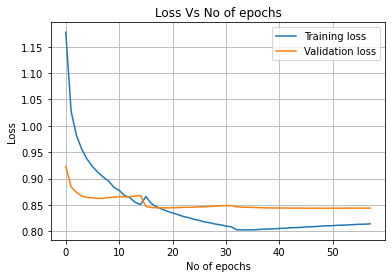

In [0]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [0]:
#Generate 1000 random samples from train and val data
#Train data
train_index = []
for i in range(X_train_padded_docs.shape[0]):
    if np.count_nonzero(X_train_padded_docs[i]!=0)>14:
        train_index.append(i)
train_index = random.sample(train_index,1000)

#Validation data
#Train data
val_index = []
for i in range(X_val_padded_docs.shape[0]):
    if np.count_nonzero(X_val_padded_docs[i]!=0)>14:
        val_index.append(i)
val_index = random.sample(val_index,1000)

In [24]:
#For train data, actual and predicted words
train_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_train_padded_docs[train_index,:],y_train_padded_docs[train_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    train_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: <start> with the things that happened a couple of weeks ago our travel has <end> 
Actual words: <start> been put off for a while <end> 
Predicted words: <start> been very helpful <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> the tickets are at my house but you are free to stop by and pick them up at your <end> 
Actual words: <start> convenience <end> 
Predicted words: <start> convenience <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> of course we are trying to avoid any commercial risks associated with marketing <end> 
Actual words: <start> this power <end> 
Predicted words: <start> and services <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> make sure it is sent as soon as you read it or your wish will not <end> 
Actual words: <start> come true <en

In [25]:
#For validation data actual and predicted words
val_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_val_padded_docs[val_index,:],y_val_padded_docs[val_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    val_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: <start> we are going to have to push back the meeting to review the model if that <end> 
Actual words: <start> ok <end> 
Predicted words: <start> is what you want to do <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> and they pay me to worry about things that can go wrong in <end> 
Actual words: <start> construction <end> 
Predicted words: <start> the system <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> please feel free to send this information to other friends and family who <end> 
Actual words: <start> may be interested <end> 
Predicted words: <start> might be interested in the group <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> you know we begin to believe that there is something we can do to <end> 
Actual words: <start> stay safe <end> 
Predict

In [26]:
#Average BLEU Score for sentences
print('BLEU Score for train data of 1000 samples:',np.round(sum(train_bleu_list)/len(train_bleu_list),3))
print('BLEU Score for validation data of 1000 samples:',np.round(sum(val_bleu_list)/len(val_bleu_list),3))

BLEU Score for train data of 1000 samples: 0.715
BLEU Score for validation data of 1000 samples: 0.699


<h1>4. Predictions

In [0]:
def predict_sentence(enc_dec_model,input_sentence):
    
    #Maximum sequence length for input and target sentence
    input_max_length = X_train_padded_docs.shape[1]
    output_max_length = y_train_padded_docs.shape[1]

    input_sentence = '<start> ' + input_sentence + ' <end>'
    
    #Convert texts to sequences
    sent = inp_tokenizer.texts_to_sequences([input_sentence])
    #Pad data
    sent = tf.keras.preprocessing.sequence.pad_sequences(sent,maxlen=input_max_length,padding='post')
    
    #print('Encoder input shape (batch_size,sequence length):',sent.shape)
    enc_hidden,enc_cell = enc_dec_model.layers[0](sent)
    #print('Encoder hidden state shape (batch_size,units):',enc_hidden.shape)
    #print('Encoder cell state shape (batch_size,units):',enc_cell.shape)
    #print(90*'-')
    
    #Boundary case
    dec_input = tf.expand_dims([out_tokenizer.word_index['<start>']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    #print('Decoder input shape (batch_size,1):',dec_input.shape)
    #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
    #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    output_sent = ''
    
    for i in range(output_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell = enc_dec_model.layers[1](dec_input,dec_hidden,dec_cell)
        #print('Decoder output shape (batch_size,vocab_size):',dec_output.shape)
        #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
        #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    
        #Get prediction from dense layer
        #Shape == (batch_size,timestep,vocab_size) == (1,1,vocab_size)
        outputs = enc_dec_model.layers[3](dec_output)
        
        #Extract predicted id from decoder output
        key = np.argmax(outputs.numpy().reshape(-1))
        
        #Get word corresponding to index
        output_sent+=out_tokenizer.index_word[key]+' '
        
        if out_tokenizer.index_word[key] == '<end>':
            return output_sent
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    return output_sent

In [0]:
predict_sentence(model,'where is')

'the way <end> '

In [0]:
predict_sentence(model,'when will the')

'best way to get together <end> '

In [0]:
predict_sentence(model,'have a')

'good weekend <end> '

In [0]:
predict_sentence(model,'ensure the')

'new date is the same <end> '

In [0]:
predict_sentence(model,'thank')

'you for your time and consideration <end> '

<h1 style="font-size:35px"><center>Encoder Decoder Attention Model

In [2]:
!wget --header="Host: doc-0o-ak-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/1/folders/1Nz-Vq0RhziotMAesPgnisN_Ti9HNQ51f" --header="Cookie: AUTH_hsr61oqao0sqa2rdskku1n6gcr67pomr_nonce=tc3g03pp0suqo; _ga=GA1.2.1509677474.1591248567" --header="Connection: keep-alive" "https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/pb164rsi80irjfu5iub508823718ee9q/1591695150000/02963250765125473783/02963250765125473783/1ZQRWKkDbx1agHPIzaX-3L9UgfpPBboQi?e=download&authuser=1&nonce=tc3g03pp0suqo&user=02963250765125473783&hash=a8ftsob7vg8c9oues2uo1rm6ap6i7g77" -c -O 'encoded_data'

--2020-06-09 09:33:35--  https://doc-0o-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/pb164rsi80irjfu5iub508823718ee9q/1591695150000/02963250765125473783/02963250765125473783/1ZQRWKkDbx1agHPIzaX-3L9UgfpPBboQi?e=download&authuser=1&nonce=tc3g03pp0suqo&user=02963250765125473783&hash=a8ftsob7vg8c9oues2uo1rm6ap6i7g77
Resolving doc-0o-ak-docs.googleusercontent.com (doc-0o-ak-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0o-ak-docs.googleusercontent.com (doc-0o-ak-docs.googleusercontent.com)|74.125.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘encoded_data’

encoded_data            [ <=>                ]   7.08M  --.-KB/s    in 0.1s    

2020-06-09 09:33:36 (55.0 MB/s) - ‘encoded_data’ saved [7426606]



<h1>1. Read Featurized data</h1> 
<h2>(Refer Word Featurization Section 3 of 2_Data_Preparation.ipynb)</h2> 

In [0]:
[X_train_padded_docs,y_train_padded_docs,X_val_padded_docs,y_val_padded_docs,inp_embedding_matrix,
                             out_embedding_matrix,inp_tokenizer,out_tokenizer] = joblib.load('encoded_data')

<h1>2. Define Model Architecture

<h2>2.1. Encoder Model

In [0]:
#Encoder class
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,enc_units,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim,weights=[embedding_matrix],
                                   mask_zero=True,name='Encoder_Embedding_layer',trainable=False)
        self.lstm = LSTM(self.enc_units,return_sequences=True,return_state=True,name='Encoder_LSTM')

    def call(self, x):
        x = self.embedding(x)
        #state_h = Hidden state output of last time step (Output of last time step)
        #state_c = Cell state output of last time step
        lstm_out, state_h, state_c = self.lstm(x)
        return lstm_out, state_h, state_c

In [5]:
input_vocab_size = len(inp_tokenizer.word_index) + 1
print('Input data Vocab size:',input_vocab_size)

Input data Vocab size: 1470


In [6]:
#Create encoder object
BATCH_SIZE = 32
encoder = Encoder(vocab_size=input_vocab_size,embedding_dim=300,embedding_matrix=inp_embedding_matrix,
                  enc_units=256,name='Encoder')

#Get data from data generator
example_input_batch, example_target_batch = X_train_padded_docs[:BATCH_SIZE], y_train_padded_docs[:BATCH_SIZE]
print('Shape of batch input data (batch_size,sequence length):',example_input_batch.shape)
print('Shape of batch output data (batch_size,sequence length):',example_target_batch.shape)

#Genearte sample ouptput and hidden state from encoder object
sample_output, sample_hidden_output, sample_cell_output = encoder(example_input_batch)
print('Shape of encoder output (batch_size,sequence length,units):',sample_output.shape)
print('Shape of hidden state output of last time step (batch_size,units):',sample_hidden_output.shape)
print('Shape of memory state output of last time step (batch_size,units):',sample_cell_output.shape)

Shape of batch input data (batch_size,sequence length): (32, 23)
Shape of batch output data (batch_size,sequence length): (32, 23)
Shape of encoder output (batch_size,sequence length,units): (32, 23, 256)
Shape of hidden state output of last time step (batch_size,units): (32, 256)
Shape of memory state output of last time step (batch_size,units): (32, 256)


<h2>2.2. Attention layer</h2>

For a particular time step of Decoder, the attention layer takes the output from the encoder (output at all time steps) and decoder output (hidden state output of decoder) at previous time step and computes the context vector. The context vector concatenated with the decoder output of previous time step is given as an input to the decoder for the current time step.

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        
    def call(self, hs, ht):
        #hs = Encoder output at all time steps
        #ht = Decoder output at last time step (Hidden state output of decoder at last time step)
        #Add time axis to ht, this is done to perform broadcast addition along time axis to calculate score
        #hs shape == (batch size,max_length,hidden size)
        #ht shape == (batch size,hidden size)
        #ht_with_time_axis shape == (batch size,1,hidden size)
        ht_with_time_axis = tf.expand_dims(ht, axis=1)
        
        #score shape == (batch size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(ht_with_time_axis) + self.W2(hs)))
        
        #Softmaxing the scores to get attention weights (alpha's)
        #attention_weights shape == (batch size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #Get context vector
        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * hs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [8]:
#Initalise Attention
attention_layer = BahdanauAttention(units=128)
sample_context_vector, sample_attention_weights = attention_layer(sample_output,sample_hidden_output)
print('Shape of context vector (batch_size,units):',sample_context_vector.shape)
print('Shape of attention weights (batch_size,sequence length,1):',sample_attention_weights.shape)

Shape of context vector (batch_size,units): (32, 256)
Shape of attention weights (batch_size,sequence length,1): (32, 23, 1)


<h2>2.3. Decoder Model

<h3>2.3.1. One Step Decoder

In [0]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,att_units):
        super(OneStepDecoder, self).__init__()
        self.attention = BahdanauAttention(units=att_units)
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix],mask_zero=True,
                                   name='Decoder_Embedding_layer',trainable=False)
        self.lstm = LSTM(dec_units,return_sequences=False,return_state=True,name='Decoder_LSTM',dropout=0.33)
        self.fc = Dense(vocab_size)
        
    def call(self, x, hidden, cell, enc_output):
        #enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(enc_output,hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x,initial_state=[hidden,cell])
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state_h, state_c, attention_weights

In [10]:
output_vocab_size = len(out_tokenizer.word_index) + 1
print('Output data Vocab size:',output_vocab_size)

Output data Vocab size: 1469


In [11]:
#Initialise one step decoder with attention
BATCH_SIZE = 32
osd = OneStepDecoder(vocab_size=output_vocab_size,embedding_dim=300,embedding_matrix=out_embedding_matrix,
                     dec_units=256,att_units=128)

#Input to decoder for first time step
dec_input = tf.expand_dims([out_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

#Geneate sample output, hidden states and attention weights from decoder object
sample_output_dec,sample_hidden_output_dec,sample_cell_output_dec,sample_attention_weights = osd(dec_input,
                                                                                                 sample_hidden_output, 
                                                                                                 sample_cell_output,
                                                                                                 sample_output)
print('One Step Decoder with Attention:')
print('Shape of decoder output (batch_size,vocab_size):',sample_output_dec.shape)
print('Shape of decoder hidden state output (batch_size,units):',sample_hidden_output_dec.shape)
print('Shape of decoder memory state output (batch_size,units):',sample_cell_output_dec.shape)
print('Shape of attention weights (batch_size,sequence length,1):',sample_attention_weights.shape)

One Step Decoder with Attention:
Shape of decoder output (batch_size,vocab_size): (32, 1469)
Shape of decoder hidden state output (batch_size,units): (32, 256)
Shape of decoder memory state output (batch_size,units): (32, 256)
Shape of attention weights (batch_size,sequence length,1): (32, 23, 1)


<h3>2.3.2. Decoder for Training

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix,dec_units,att_units,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(vocab_size=self.vocab_size,embedding_dim=self.embedding_dim,
                                              embedding_matrix=embedding_matrix,
                                              dec_units=self.dec_units,
                                              att_units=self.att_units)
        
    #@tf.function
    def call(self,decoder_input,decoder_hidden_state,decoder_cell_state,encoder_outputs):
        
        #Decoder must output words after <start> token hence sequence length is reduced by 1
        all_outputs = tf.TensorArray(tf.float32,size=decoder_input.shape[1]-1,name='Output_arrays')
        
        #Initialise the hidden and cell states of decoder
        hidden_output_dec = decoder_hidden_state
        cell_output_dec = decoder_cell_state
        
        #for each timestep in decoder input (output after <start> token)
        for timestep in range(decoder_input.shape[1]-1):
            #Get the output, hidden states from one step decoder
            output_dec,hidden_output_dec,cell_output_dec,_ = self.onestep_decoder(decoder_input[:,timestep:timestep+1],
                                                                                  hidden_output_dec,cell_output_dec,
                                                                                  encoder_outputs)
            
            #output_dec shape == (batch_size,vocab_size)
            #Storing all outputs
            all_outputs = all_outputs.write(timestep,output_dec)
        #all_outputs shape after stacking == (timestep-1,batch_size,vocab_size)
        #all_outputs shape after transpose == (batch_size,timestep-1,vocab_size)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [13]:
#Initialise decoder
decoder = Decoder(vocab_size=output_vocab_size,embedding_dim=300,embedding_matrix=out_embedding_matrix,
                  dec_units=256,att_units=128)

#Generate output from decoder
all_outputs = decoder(example_target_batch,sample_hidden_output,sample_cell_output,sample_output)
print('Decoder with Attention:')
print('Shape of decoder input (batch_size,sequence length):',example_target_batch.shape)
print('Shape of decoder output (batch_size,sequence length-1,vocab_size):',all_outputs.shape)

Decoder with Attention:
Shape of decoder input (batch_size,sequence length): (32, 23)
Shape of decoder output (batch_size,sequence length-1,vocab_size): (32, 22, 1469)


<h2>2.4. Loss function

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    
    #Identify zeros in real tensor/Creating masking tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #Calculate log loss for each class
    loss_ = loss_object(real, pred)
    #Change data type of mask
    mask = tf.cast(mask, dtype=loss_.dtype)
    #Calculate loss considering masking
    loss_ *= mask

    return tf.reduce_mean(loss_)

<h2>2.5. Model

In [0]:
class Encoder_Decoder_Attention_Model(tf.keras.models.Model):
    def __init__(self, input_vocab_size,output_vocab_size,embedding_dim,enc_embedding_matrix,dec_embedding_matrix,units,
                 att_units,**kwargs):
        super(Encoder_Decoder_Attention_Model,self).__init__(**kwargs)
        self.encoder = Encoder(vocab_size=input_vocab_size, embedding_dim=embedding_dim,embedding_matrix=enc_embedding_matrix,
                               enc_units=units,name='Encoder_layer')
        self.decoder = Decoder(vocab_size=output_vocab_size, embedding_dim=embedding_dim,embedding_matrix=dec_embedding_matrix,
                               dec_units=units,att_units=att_units,name='Decoder_layer')
        
    def call(self, inputs):
        #Inputs will contain encoder input and decoder input
        #Separate encoder and decoder inputs
        encoder_inputs, decoder_inputs = inputs[0], inputs[1]
        
        #Genearte output and hidden states from encoder object
        encoder_outputs, enc_hidden_output, enc_cell_output = self.encoder(encoder_inputs)

        #Generate output from decoder
        #Initialise hidden states of decoder with hidden states of encoder
        all_outputs = self.decoder(decoder_inputs,enc_hidden_output,enc_cell_output,encoder_outputs)
        
        return all_outputs

<h2>2.6. Model Evaluation

In [0]:
#Function returns texts from a sequence
def get_text_from_seq(sequence,tokenizer):
    sent =''
    for i in sequence:
        if i!=0:
            sent+=tokenizer.index_word[i]+' '
    return sent

In [0]:
#Function to get bleu score for a sentence
def get_bleu_score(enc_dec_model,input_seq,expected_output_seq):
    
    inp_max_length = X_train_padded_docs.shape[1]
    out_max_length = y_train_padded_docs.shape[1]
    
    #Get output from encoder
    enc_outputs,enc_hidden,enc_cell = enc_dec_model.layers[0](input_seq.reshape(1,inp_max_length))
    
    #Boundary case for decoder
    dec_input = tf.expand_dims([out_tokenizer.word_index['<start>']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    
    #Predicted output sequence
    #Add <start> token to output sequence
    output_seq = [out_tokenizer.word_index['<start>']]
    
    #The model will start predicting after start token, hence max_length is subtracted by 1
    for i in range(out_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell,_ = enc_dec_model.layers[1].onestep_decoder(dec_input,dec_hidden,dec_cell,enc_outputs)
        
        #Extract predicted id from decoder output
        key = tf.argmax(dec_output[0]).numpy()
        
        output_seq.append(key)
        
        if out_tokenizer.index_word[key] == '<end>':
            #Get texts from input sentence
            input_sent = get_text_from_seq(input_seq,out_tokenizer)
            #Get texts from sequence for actual sentence
            actual = get_text_from_seq(expected_output_seq,out_tokenizer)
            #Get texts from sequence for predicted sentence
            prediction = get_text_from_seq(output_seq,out_tokenizer)
            return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    input_sent = get_text_from_seq(input_seq,out_tokenizer)
    actual = get_text_from_seq(expected_output_seq,out_tokenizer)
    prediction = get_text_from_seq(output_seq,out_tokenizer)
    return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())

<h1>3. Model Training

In [0]:
#Set Parameters
input_vocab_size = len(inp_tokenizer.word_index) + 1  
output_vocab_size = len(out_tokenizer.word_index) + 1  
#Encoding and decoding Embedding layer dimension
embedding_dim = 300
enc_embedding_matrix = inp_embedding_matrix
dec_embedding_matrix = out_embedding_matrix
#Encoding and decoding LSTM layer units
units = 128
att_units = units

#Initialise object for Model class
model = Encoder_Decoder_Attention_Model(input_vocab_size,output_vocab_size,embedding_dim,enc_embedding_matrix,
                                        dec_embedding_matrix,units,att_units,name='Encoder_Decoder_Attention_Model')

In [54]:
#Max sequence length
model.build(input_shape=[(None,X_train_padded_docs.shape[1]),(None,y_train_padded_docs.shape[1])])
model.summary()

Model: "Encoder_Decoder_Attention_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_layer (Encoder)      multiple                  660648    
_________________________________________________________________
Decoder_layer (Decoder)      multiple                  948538    
Total params: 1,609,186
Trainable params: 727,486
Non-trainable params: 881,700
_________________________________________________________________


In [0]:
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X)).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
#Create folder to save model weights
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [57]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 10

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list=[checkpoint,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history1 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/10
642/642 [==============================] - ETA: 0s - loss: 1.2220
Epoch 00001: loss improved from inf to 1.22204, saving model to model_save/weights-01-1.2220.hdf5
642/642 [==============================] - 190s 296ms/step - loss: 1.2220 - val_loss: 0.9487
Epoch 2/10
642/642 [==============================] - ETA: 0s - loss: 1.0319
Epoch 00002: loss improved from 1.22204 to 1.03190, saving model to model_save/weights-02-1.0319.hdf5
642/642 [==============================] - 179s 278ms/step - loss: 1.0319 - val_loss: 0.9070
Epoch 3/10
642/642 [==============================] - ETA: 0s - loss: 0.9832
Epoch 00003: loss improved from 1.03190 to 0.98319, saving model to model_save/weights-03-0.9832.hdf5
642/642 [==============================] - 179s 279ms/step - loss: 0.9832 - val_loss: 0.8954
Epoch 4/10
642/642 [==============================] - ETA: 0s - loss: 0.9560
Epoch 00004: loss improved from 0.98319 to 0.95603, saving model to model_save/weights-04-0.9560.hdf5
642/642 [

In [58]:
joblib.dump(history1.history,'history1')

['history1']

In [0]:
#Save weights
model.save_weights('best_model1.h5')

In [60]:
train_parameters = model.evaluate([X_train_padded_docs,y_train_padded_docs],y_train_padded_docs[:,1:],
                                  verbose=1,batch_size=BATCH_SIZE)

643/643 [==============================] - 61s 95ms/step - loss: 0.8313


In [61]:
val_parameters = model.evaluate([X_val_padded_docs,y_val_padded_docs],y_val_padded_docs[:,1:],verbose=1,batch_size=BATCH_SIZE)

120/120 [==============================] - 11s 95ms/step - loss: 0.9034


In [0]:
#Load weights
model.load_weights('best_model1.h5')

In [63]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 512
epochs = 20

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss',patience=8,verbose=1,mode='min',restore_best_weights=True)

#Tensorboard
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#Callback list
callback_list=[checkpoint,reduce_lr,terminate,tensorboard_callback]

#Generate data
train = data_generator((X_train_padded_docs,y_train_padded_docs),y_train_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,
                       shuffle=True)
val = data_generator((X_val_padded_docs,y_val_padded_docs),y_val_padded_docs[:,1:],BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history2 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)

Epoch 1/20
642/642 [==============================] - ETA: 0s - loss: 0.8532
Epoch 00001: loss improved from inf to 0.85317, saving model to model_save/weights-01-0.8532.hdf5
642/642 [==============================] - 189s 295ms/step - loss: 0.8532 - val_loss: 0.8859 - lr: 0.0010
Epoch 2/20
642/642 [==============================] - ETA: 0s - loss: 0.8416
Epoch 00002: loss improved from 0.85317 to 0.84157, saving model to model_save/weights-02-0.8416.hdf5
642/642 [==============================] - 177s 276ms/step - loss: 0.8416 - val_loss: 0.8847 - lr: 0.0010
Epoch 3/20
642/642 [==============================] - ETA: 0s - loss: 0.8370
Epoch 00003: loss improved from 0.84157 to 0.83702, saving model to model_save/weights-03-0.8370.hdf5
642/642 [==============================] - 178s 277ms/step - loss: 0.8370 - val_loss: 0.8845 - lr: 0.0010
Epoch 4/20
642/642 [==============================] - ETA: 0s - loss: 0.8340
Epoch 00004: loss improved from 0.83702 to 0.83399, saving model to mode

In [64]:
joblib.dump(history2.history,'history2')

['history2']

In [0]:
#Save weights
model.save_weights('best_model2.h5')

In [0]:
h1 = joblib.load('history1')
h2 = joblib.load('history2')

In [0]:
loss = h1['loss']+h2['loss']
val_loss = h1['val_loss']+h2['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

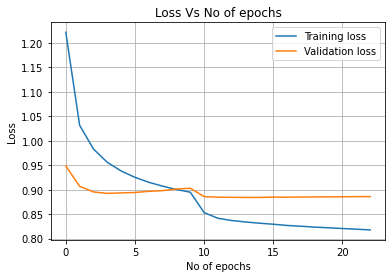

In [68]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [0]:
#Generate 1000 random samples from train and val data
#Train data
train_index = []
for i in range(X_train_padded_docs.shape[0]):
    if np.count_nonzero(X_train_padded_docs[i]!=0)>14:
        train_index.append(i)
train_index = random.sample(train_index,1000)

#Validation data
#Train data
val_index = []
for i in range(X_val_padded_docs.shape[0]):
    if np.count_nonzero(X_val_padded_docs[i]!=0)>14:
        val_index.append(i)
val_index = random.sample(val_index,1000)

In [70]:
#For train data, actual and predicted words
train_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_train_padded_docs[train_index,:],y_train_padded_docs[train_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    train_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: <start> in issue manage see development review in service not for you set end call that <end> 
Actual words: <start> day <end> 
Predicted words: <start> matter <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> the of changes look you to you it in our out as this change <end> 
Actual words: <start> few days <end> 
Predicted words: <start> few days <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> together with back has provided me further look your have for be www was is <end> 
Actual words: <start> will work with your schedules <end> 
Predicted words: <start> what you think <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> me questions if chance you please and to it are them information appropriate on this just removed on <end> 
Actual words: <start> course 

In [71]:
#For validation data actual and predicted words
val_bleu_list = []
counter = 0
for i,j in tqdm(zip(X_val_padded_docs[val_index,:],y_val_padded_docs[val_index,:])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(model,i,j)
    val_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%100==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

Input sentence: <start> link know loss complete move to of at you register any as this bad clearly <end> 
Actual words: <start> when you check out <end> 
Predicted words: <start> and let me know if you have any questions <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> service is each give comments to tomorrow when what number not in coming are possible can is as <end> 
Actual words: <start> town <end> 
Predicted words: <start> the office <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> the process that back on to but it support then know today to hold this <end> 
Actual words: <start> group <end> 
Predicted words: <start> link below <end> 
------------------------------------------------------------------------------------------
Input sentence: <start> the needed look that and get it always them sure a will we make <end> 
Actual words: <star

In [72]:
#Average BLEU Score for sentences
print('BLEU Score for train data of 1000 samples:',np.round(sum(train_bleu_list)/len(train_bleu_list),3))
print('BLEU Score for validation data of 1000 samples:',np.round(sum(val_bleu_list)/len(val_bleu_list),3))

BLEU Score for train data of 1000 samples: 0.7
BLEU Score for validation data of 1000 samples: 0.694


<h1>4. Predictions

In [0]:
def predict_sentence(enc_dec_model,input_sentence):
    
    #Maximum sequence length for input and target sentence
    inp_max_length = X_train_padded_docs.shape[1]
    out_max_length = y_train_padded_docs.shape[1]
    
    #Attention plot
    attention_plot = np.zeros((inp_max_length,out_max_length))
    
    input_sentence = '<start> ' + input_sentence + ' <end>'
    
    #Convert texts to sequences
    sent = inp_tokenizer.texts_to_sequences([input_sentence])
    #Pad data
    sent = tf.keras.preprocessing.sequence.pad_sequences(sent,maxlen=inp_max_length,padding='post')
    
    #print('Encoder input shape (batch_size,sequence length):',sent.shape)
    enc_outputs,enc_hidden,enc_cell = enc_dec_model.layers[0](sent)
    #print('Encoder output shape (batch_size,sequence lengths,units):',enc_outputs.shape)
    #print('Encoder hidden state shape (batch_size,units):',enc_hidden.shape)
    #print('Encoder cell state shape (batch_size,units):',enc_cell.shape)
    #print(90*'-')
    
    #Boundary case
    dec_input = tf.expand_dims([out_tokenizer.word_index['<start>']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    #print('Decoder input shape (batch_size,1):',dec_input.shape)
    #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
    #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    output_sent = ''
    
    for i in range(out_max_length-1):
        #Get prediction from onestep_decoder
        dec_output,dec_hidden,dec_cell,attention_weights = enc_dec_model.layers[1].onestep_decoder(dec_input,dec_hidden,
                                                                                               dec_cell,enc_outputs)
        #print('Decoder output shape (batch_size,vocab_size):',dec_output.shape)
        #print('Decoder hidden state shape (batch_size,units):',dec_hidden.shape)
        #print('Decoder cell state shape (batch_size,units):',dec_cell.shape)
    
        #Storing attention weights
        attention_weights = tf.reshape(attention_weights,(-1,))
        attention_plot[i] = attention_weights.numpy()
        
        #Extract predicted id from decoder output
        key = tf.argmax(dec_output[0]).numpy()
        #Get word corresponding to index
        output_sent+=out_tokenizer.index_word[key]+' '
        
        if out_tokenizer.index_word[key] == '<end>':
            return output_sent,input_sentence,attention_plot
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 0)
    
    return output_sent,input_sentence,attention_plot

In [0]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention#write_the_encoder_and_decoder_model
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def generate_sentence(enc_dec_model,input_sentence):
    #Get prediction from model
    result,sentence,attention_plot = predict_sentence(enc_dec_model,input_sentence)
    print('Input sentence:',sentence)
    print('Predicted words:',result)
    #Plot Attention plots
    attention_plot = attention_plot[:len(result.split()),:len(sentence.split())]
    plot_attention(attention_plot, sentence.split(), result.split())

Input sentence: <start> thank you <end>
Predicted words: for your time and consideration <end> 


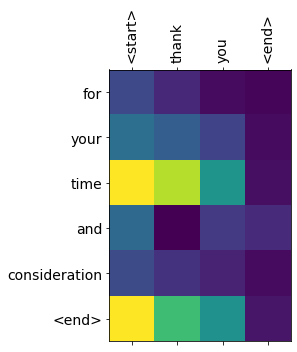

In [76]:
input_sentence = 'thank you'
generate_sentence(model,input_sentence)

Input sentence: <start> hope it <end>
Predicted words: is going well <end> 


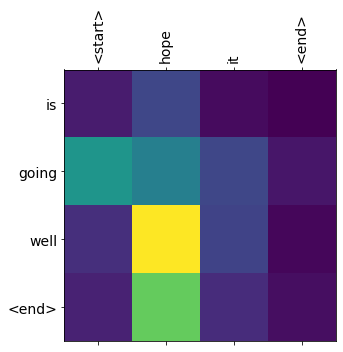

In [77]:
input_sentence = 'hope it'
generate_sentence(model,input_sentence)

Input sentence: <start> can you <end>
Predicted words: please let me know if you have any questions or need additional information <end> 


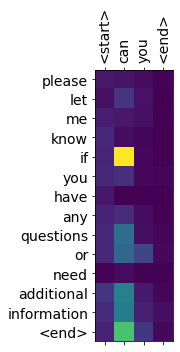

In [78]:
input_sentence = 'can you'
generate_sentence(model,input_sentence)

Input sentence: <start> give me <end>
Predicted words: a call if you have any questions or need any further information <end> 


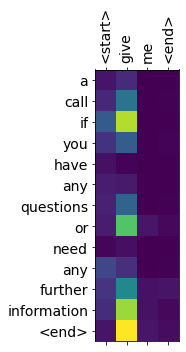

In [79]:
input_sentence = 'give me'
generate_sentence(model,input_sentence)

Input sentence: <start> are you <end>
Predicted words: doing this <end> 


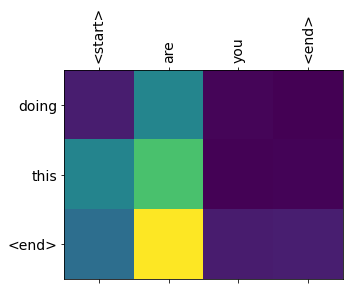

In [80]:
input_sentence = 'are you'
generate_sentence(model,input_sentence)

<h1 style="font-size:35px"><center>GPT2 Model

In [1]:
#Import libraries
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from nltk.translate import bleu_score

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
#Load GPt2 model
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 366Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 83.7Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 335Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:03, 140Mit/s]                                   
Fetching model.ckpt.index: 1.05Mit [00:00, 208Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 169Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 145Mit/s]                                                       


In [3]:
#Mount Google Drive
gpt2.mount_gdrive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<h2>(Refer GPT2 Word Featurization Section 1 of 2_Data_Preparation.ipynb)</h2> 

In [0]:
#Dataset
file_name = "train_preprocessed_data.csv"

In [0]:
#Fine-tune GPT2 model
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=500,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=50
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt


100%|██████████| 1/1 [00:00<00:00, 18.24it/s]

Loading dataset...


dataset has 1000868 tokens
Training...
[10 | 18.77] loss=1.31 avg=1.31
[20 | 31.39] loss=1.20 avg=1.26
[30 | 44.02] loss=1.18 avg=1.23
[40 | 56.71] loss=1.17 avg=1.21
[50 | 69.42] loss=1.16 avg=1.20
======== SAMPLE 1 ========
endoftext|>
<|startoftext|>if it is not then it does not really fit<|endoftext|>
<|startoftext|>see your calendar<|endoftext|>
<|startoftext|>just let me know if there are any problems<|endoftext|>
<|startoftext|>if you have anything else do not hesitate to let us know<|endoftext|>
<|startoftext|>please get the details in before you send them out<|endoftext|>
<|startoftext|>this will be a nice change of pace<|endoftext|>
<|startoftext|>thanks for your help<|endoftext|>
<|startoftext|>please let me know if you would like him in this meeting<|endoftext|>
<|startoftext|>see if you can get me a copy<|endoftext|>
<|startoftext|>if you want this to work for you then please let me know<|endoftext|>
<|startoftext|>you will have to ask for a signature on your records<|endo

In [0]:
#Copy GPT2 model to Google Drive
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

In [0]:
#Load GPT2 model from Google Drive
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

In [3]:
#Load trained model
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

Loading checkpoint checkpoint/run1/model-500
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-500


In [6]:
!wget --header="Host: doc-10-ak-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/1/folders/1GPJE1WQq27nrFOlJwMRDMIO-6HbzxvVu" --header="Cookie: AUTH_hsr61oqao0sqa2rdskku1n6gcr67pomr=02963250765125473783|1591938525000|hldd6k0bf58ot9hkud0vlq42tnfjpnm8; _ga=GA1.2.1509677474.1591248567" --header="Connection: keep-alive" "https://doc-10-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/ft2nrpemmsfv4pa4tavlle3puo82k486/1591938675000/02963250765125473783/02963250765125473783/1HMgJBTT6CEU3fB9a40FxCp-PhtEgjZfj?e=download&authuser=1" -c -O 'train_final_data.csv'

--2020-06-12 05:12:28--  https://doc-10-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/ft2nrpemmsfv4pa4tavlle3puo82k486/1591938675000/02963250765125473783/02963250765125473783/1HMgJBTT6CEU3fB9a40FxCp-PhtEgjZfj?e=download&authuser=1
Resolving doc-10-ak-docs.googleusercontent.com (doc-10-ak-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-10-ak-docs.googleusercontent.com (doc-10-ak-docs.googleusercontent.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_final_data.csv’

train_final_data.cs     [ <=>                ]  21.79M   116MB/s    in 0.2s    

2020-06-12 05:12:29 (116 MB/s) - ‘train_final_data.csv’ saved [22853484]



In [7]:
!wget --header="Host: doc-0g-ak-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/u/1/folders/1GPJE1WQq27nrFOlJwMRDMIO-6HbzxvVu" --header="Cookie: AUTH_hsr61oqao0sqa2rdskku1n6gcr67pomr=02963250765125473783|1591938525000|hldd6k0bf58ot9hkud0vlq42tnfjpnm8; _ga=GA1.2.1509677474.1591248567" --header="Connection: keep-alive" "https://doc-0g-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/7hvjf16pnf3aj0u2rnhuoke3jnpips2o/1591938675000/02963250765125473783/02963250765125473783/1kdRszXCTviPXxWQcpTFTf9AXoqhowuE0?e=download&authuser=1" -c -O 'val_final_data.csv'

--2020-06-12 05:12:32--  https://doc-0g-ak-docs.googleusercontent.com/docs/securesc/qbvov0hd66fbepcf5v8uge9fuarie7t4/7hvjf16pnf3aj0u2rnhuoke3jnpips2o/1591938675000/02963250765125473783/02963250765125473783/1kdRszXCTviPXxWQcpTFTf9AXoqhowuE0?e=download&authuser=1
Resolving doc-0g-ak-docs.googleusercontent.com (doc-0g-ak-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-0g-ak-docs.googleusercontent.com (doc-0g-ak-docs.googleusercontent.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘val_final_data.csv’

val_final_data.csv      [ <=>                ]   4.36M  --.-KB/s    in 0.04s   

2020-06-12 05:12:32 (97.0 MB/s) - ‘val_final_data.csv’ saved [4569448]



<h2>(Refer GPT2 Word Featurization Section 2 of 2_Data_Preparation.ipynb)</h2> 

In [0]:
train_final_data = pd.read_csv('train_final_data.csv')
val_final_data = pd.read_csv('val_final_data.csv')

In [9]:
train_final_data.head()

,X,y
0,<|startoftext|>it,looks like we should have them soon
1,<|startoftext|>it looks,like we should have them soon
2,<|startoftext|>it looks like,we should have them soon
3,<|startoftext|>it looks like we,should have them soon
4,<|startoftext|>it looks like we should,have them soon


In [5]:
val_final_data.head()

,X,y,X_length
0,<|startoftext|>but again that,might be just what the two utilities receive,3
1,<|startoftext|>but again that might,be just what the two utilities receive,4
2,<|startoftext|>but again that might be,just what the two utilities receive,5
3,<|startoftext|>but again that might be just,what the two utilities receive,6
4,<|startoftext|>but again that might be just what,the two utilities receive,7


In [0]:
#Compute loss for train and validation data
#Generate 100 random samples from train and val data
#Train data
train_index = []
for i in range(train_final_data.shape[0]):
    if len(train_final_data.X.iloc[i].split())>13:
        train_index.append(i)
train_index = random.sample(train_index,100)

#Validation data
#Train data
val_index = []
for i in range(val_final_data.shape[0]):
    if len(val_final_data.X.iloc[i].split())>13:
        val_index.append(i)
val_index = random.sample(val_index,100)

In [0]:
def predict_text(text):
    return gpt2.generate(sess, run_name='run1',length=25,prefix=text,truncate="<|endoftext|>",include_prefix=False,
                         return_as_list=True)[0]

In [0]:
def get_bleu_score(input_sent,actual):
    prediction = predict_text(input_sent)
    return input_sent,actual,prediction,bleu_score.sentence_bleu([actual.split()],prediction.split())

In [14]:
#For train data, actual and predicted words
train_bleu_list = []
counter = 0
for i,j in tqdm(zip(train_final_data.X.iloc[train_index],train_final_data.y.iloc[train_index])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(i,j)
    train_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%10==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input sentence: <|startoftext|>i would love the opportunity to talk with you further if you think this might
Actual words: be of interest to you
Predicted words:  be of interest to you
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>if either of you have any questions or know of more things to do please
Actual words: let is get together and discuss
Predicted words:  let me know
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>please call if you have any questions or would like to discuss in greater
Actual words: detail
Predicted words:  detail
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>i do not want that to be the basis on which the decision is
Actual words: made
Predicted words:  made
-------------------------------------------------------------------------------

In [17]:
#Average BLEU Score for sentences
print('BLEU Score for train data of 100 samples:',np.round(sum(train_bleu_list)/len(train_bleu_list),3))

BLEU Score for train data of 100 samples: 0.429


In [9]:
#For validation data, actual and predicted words
val_bleu_list = []
counter = 0
for i,j in tqdm(zip(val_final_data.X.iloc[val_index],val_final_data.y.iloc[val_index])):
    counter+=1
    inp, a, p, bleu = get_bleu_score(i,j)
    val_bleu_list.append(bleu)
    #Print some actual and predicted words
    if counter%10==0:
        print('Input sentence:',inp)
        print('Actual words:',a)
        print('Predicted words:',p)
        print(90*'-')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input sentence: <|startoftext|>i would like to know by then what we like and do not like about
Actual words: them and how to approach possible changes
Predicted words:  you guys
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>however the states would be able to determine how and when this would be
Actual words: done
Predicted words:  done
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>if you want to discuss it further please feel free to give me a
Actual words: call
Predicted words:  call
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>if you are not the correct person that should look at this please let me
Actual words: know
Predicted words:  know
------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input sentence: <|startoftext|>please feel free to contact me or have your counsel contact me with any questions regarding
Actual words: the attached
Predicted words:  this matter
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>if you wish to know that you are safe cause another to know that they
Actual words: are safe
Predicted words:  are not safe cause
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>a conversation with you would help me to better understand client needs in the competitive market
Actual words: for information
Predicted words:  and in the energy industry
------------------------------------------------------------------------------------------
Input sentence: <|startoftext|>please make a note of his information so you can work with him in
Actual words: the future
Predicted words:  the future
-------------------------------

In [10]:
#Average BLEU Score for sentences
print('BLEU Score for validation data of 100 samples:',np.round(sum(val_bleu_list)/len(val_bleu_list),3))

BLEU Score for validation data of 100 samples: 0.399


In [11]:
#Predictions from model
gpt2.generate(sess, run_name='run1',
             length=25,
             prefix="<|startoftext|>thank you for",
             truncate="<|endoftext|>",
             include_prefix=False)

 your assistance and support of the group


In [12]:
#Predictions from model
gpt2.generate(sess, run_name='run1',
             length=25,
             prefix="<|startoftext|>where is",
             truncate="<|endoftext|>",
             include_prefix=False)

 my car


In [13]:
#Predictions from model
gpt2.generate(sess, run_name='run1',
             length=25,
             prefix="<|startoftext|>have a",
             truncate="<|endoftext|>",
             include_prefix=False)

 good weekend


In [14]:
#Predictions from model
gpt2.generate(sess, run_name='run1',
             length=25,
             prefix="<|startoftext|>ensure the",
             truncate="<|endoftext|>",
             include_prefix=False)

 following
